In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ppkm-twitter-dataset/dataset_rzl.csv
/kaggle/input/ppkm-twitter-dataset/stopword_rzl.txt


> # Before

> Install Library

In [2]:
!pip install swifter
!pip install Sastrawi

     |████████████████████████████████| 633 kB 894 kB/s 
     |████████████████████████████████| 579 kB 3.8 MB/s 
     |████████████████████████████████| 9.9 MB 5.9 MB/s 
     |████████████████████████████████| 17.2 MB 18.2 MB/s 
     |████████████████████████████████| 48.5 MB 25.9 MB/s 
  Created wheel for swifter: filename=swifter-1.0.7-py3-none-any.whl size=13976 sha256=cf5b7ba778a9c0b02b2886e629678296094fdb6ab1674f0dc626179cdfb53a88
  Stored in directory: /root/.cache/pip/wheels/49/44/5b/2c3fcb044734cb9969adbeeab8de419e571fb3d9d0b9f62dae
Successfully built swifter
  Attempting uninstall: pandas
    Found existing installation: pandas 1.2.2
    Uninstalling pandas-1.2.2:
      Successfully uninstalled pandas-1.2.2
  Attempting uninstall: ray
    Found existing installation: ray 1.2.0
    Uninstalling ray-1.2.0:
      Successfully uninstalled ray-1.2.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 3.0.0
    Uninstalling pyarrow-3.0.0:
      Successfully uni

> Import library

In [3]:
# matplot
import matplotlib
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

#nltk
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

#sastrawi
import Sastrawi.Stemmer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
import swifter

#util
import re
import string
from string import digits
from collections import Counter
import re
import pickle
import numpy as np
import pandas as pd
#import inline as inline

> Pendeklarasian Dataset

In [4]:
#importing the dataset
DATASET_COLUMNS  = ["kategori","text"]
DATASET_ENCODING = "ISO-8859-1"
dataset = pd.read_csv('/kaggle/input/ppkm-twitter-dataset/dataset_rzl.csv',
                      encoding=DATASET_ENCODING , names=DATASET_COLUMNS)

> Melihat kuantitas data yang dimiliki

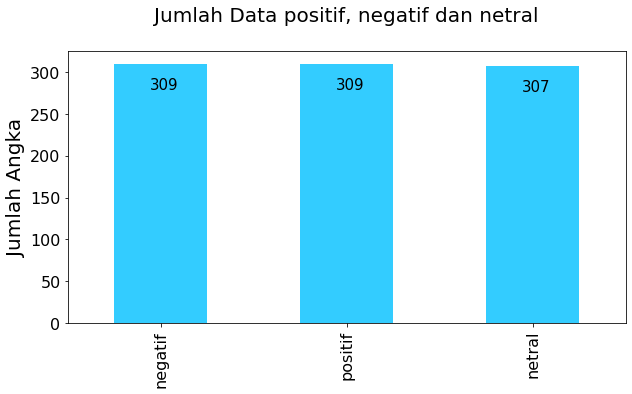

In [5]:
ax = dataset['kategori'].value_counts().plot(kind='bar', figsize=(10,5),fontsize=16,color='#33ccff')
ax.set_title('Jumlah Data positif, negatif dan netral', size=20, pad=30)
ax.set_ylabel('Jumlah Angka', fontsize=20)

for i in ax.patches:
    ax.text(i.get_x() + 0.19, i.get_height() - 30, str(round(i.get_height(), 5)), fontsize=15)

> # During

> Pre-Processing

In [6]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [7]:
def preprocessing(data):
    fitur_ekstraksi0 = []
    for cuitan in range(0, len(data)):
        tmp = str(data[cuitan]).lower()
        fitur_ekstraksi0.append(tmp)
    fitur_ekstraksi1 = []
    for cuitan in range(0, len(fitur_ekstraksi0)):
        tmp = fitur_ekstraksi0[cuitan].translate(str.maketrans(' ', ' ', digits))  # membuang karakter angka
        fitur_ekstraksi1.append(tmp)
    fitur_ekstraksi2 = []
    for cuitan in range(0, len(fitur_ekstraksi1)):
        tmp = fitur_ekstraksi1[cuitan].translate(str.maketrans(' ', ' ', string.punctuation))  # membuang karakter
        fitur_ekstraksi2.append(tmp)
    fitur_ekstraksi3 = []
    # fitur_ekstraksi = []
    for cuitan in range(0, len(fitur_ekstraksi2)):
        tmp = re.sub(r'\\W', ' ',str(fitur_ekstraksi2[cuitan])) # membuang karakter khusus selain angka dan huruf
        tmp = re.sub(r'\\s+[a-zA-Z]\\s+', ' ',str(fitur_ekstraksi2[cuitan])) # membuang kata yang hanya satu huruf
        tmp = re.sub(r'\\^[a-zA-Z]\\s+', ' ',str(fitur_ekstraksi2[cuitan])) # membuang kata yang hanya satu huruf dari awal
        tmp = re.sub(r'\\s+', ' ',str(fitur_ekstraksi2[cuitan])) # mengganti spasi ganda dengan spasi tunggal
        fitur_ekstraksi3.append(tmp)
    fitur_ekstraksi5 = []
    for cuitan in range(0, len(fitur_ekstraksi3)):
        tmp = word_tokenize(str(fitur_ekstraksi3[cuitan]))
        fitur_ekstraksi5.append(tmp)
    return fitur_ekstraksi5

In [8]:
stopwordp1 = open('/kaggle/input/ppkm-twitter-dataset/stopword_rzl.txt', 'r')
stopwordp2 = stopwordp1.read()
stopwordp = word_tokenize(stopwordp2)

In [9]:
def swr(a, b):
    filtered_sentence = []
    for w in a:
        if w not in b:
            filtered_sentence.append(w)
    return filtered_sentence

In [10]:
fitur = dataset.iloc[:,1].values
labels = dataset.iloc[:,0].values

In [11]:
callbackvalue = preprocessing(fitur)

In [12]:
def stopw(datanext):
    fitur_ekstraksiku = []
    for cuitan in range(0, len(datanext)):
        tmp = swr(datanext[cuitan], stopwordp)
        fitur_ekstraksiku.append(tmp)
    return fitur_ekstraksiku
fitur_ekstraksinext = stopw(callbackvalue)
print(fitur_ekstraksinext[15])
print('\\n')

['ayo', 'luurr', 'nderek', 'pemerintah', 'mawon', 'ojo', 'lali', 'nganggo', 'masker', 'jaga', 'jarak', 'jaga', 'kesehatanben', 'slamet', 'kabehnek', 'rezeki', 'iso', 'golek', 'i', 'nek', 'nyowo', 'ming', 'sijidiemaneman', 'yo', 'lurjatim', 'lawancorona', 'madiunraya']
\n


In [13]:
def identity_tokenizer(text):
    return text

from sklearn.feature_extraction.text import TfidfVectorizer

vektor_kata = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False)
fitur_ekstraksisiap = vektor_kata.fit_transform(fitur_ekstraksinext).toarray()

fitur_ekstraksi = []
for cuitan in range(0, len(callbackvalue)):
    tmp = fitur_ekstraksisiap[cuitan]
    fitur_ekstraksi.append(tmp)

fitur_ekstraksitest = []
for cuitan in range(len(callbackvalue), len(fitur_ekstraksisiap)):
    tmp = fitur_ekstraksisiap[cuitan]
    fitur_ekstraksitest.append(tmp)

> Pembagian Data Training dan Data Test

In [14]:
from sklearn.model_selection import train_test_split
    
X_train,X_test,y_train,y_test = train_test_split(fitur_ekstraksi,labels,test_size=0.2,random_state=42, shuffle=True, stratify=labels)

> Pembangunan Model

In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.metrics import accuracy_score, classification_report

In [16]:
gnb = GaussianNB()
KNN = KNeighborsClassifier(n_neighbors=1)
MNB = MultinomialNB()
BNB = BernoulliNB()
LR = LogisticRegression()
SDG = SGDClassifier()
SVC = SVC()
LSVC = LinearSVC()
NSVC = NuSVC()

> # After

> Build Model

In [17]:
def model_Evaluate(model):
    
    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))

> Hasil Proses

GaussianNB

In [18]:
gnb.fit(X_train, y_train)
y2_GNB_model = gnb.predict(X_test)
print("GaussianNB Accuracy :", accuracy_score(y_test, y2_GNB_model))
print("")
model_Evaluate(gnb)

GaussianNB Accuracy : 0.7081081081081081

              precision    recall  f1-score   support

     negatif       0.83      0.71      0.77        62
      netral       0.59      0.77      0.67        61
     positif       0.75      0.65      0.70        62

    accuracy                           0.71       185
   macro avg       0.73      0.71      0.71       185
weighted avg       0.73      0.71      0.71       185



KNeighborsClassifier

In [19]:
KNN.fit(X_train,y_train)
y2_KNN_model = KNN.predict(X_test)
print("KNN Accuracy :", accuracy_score(y_test, y2_KNN_model))
print("")
model_Evaluate(KNN)

KNN Accuracy : 0.7135135135135136

              precision    recall  f1-score   support

     negatif       0.72      0.66      0.69        62
      netral       0.67      0.74      0.70        61
     positif       0.75      0.74      0.75        62

    accuracy                           0.71       185
   macro avg       0.72      0.71      0.71       185
weighted avg       0.72      0.71      0.71       185



MultinomialNB

In [20]:
MNB.fit(X_train,y_train)
y2_MNB_model = MNB.predict(X_test)
print("MNB Accuracy :", accuracy_score(y_test, y2_MNB_model))
print("")
model_Evaluate(MNB)

MNB Accuracy : 0.7351351351351352

              precision    recall  f1-score   support

     negatif       0.75      0.82      0.78        62
      netral       0.72      0.67      0.69        61
     positif       0.73      0.71      0.72        62

    accuracy                           0.74       185
   macro avg       0.73      0.73      0.73       185
weighted avg       0.73      0.74      0.73       185



BernoulliNB

In [21]:
BNB.fit(X_train,y_train)
y2_BNB_model = BNB.predict(X_test)
print("BNB Accuracy :", accuracy_score(y_test, y2_BNB_model))
print("")
model_Evaluate(BNB)

BNB Accuracy : 0.7189189189189189

              precision    recall  f1-score   support

     negatif       0.70      0.84      0.76        62
      netral       0.72      0.69      0.71        61
     positif       0.74      0.63      0.68        62

    accuracy                           0.72       185
   macro avg       0.72      0.72      0.72       185
weighted avg       0.72      0.72      0.72       185



LogisticRegression

In [22]:
LR.fit(X_train,y_train)
y2_LR_model = LR.predict(X_test)
print("LR Accuracy :", accuracy_score(y_test, y2_LR_model))
print("")
model_Evaluate(LR)

LR Accuracy : 0.7567567567567568

              precision    recall  f1-score   support

     negatif       0.73      0.85      0.79        62
      netral       0.86      0.62      0.72        61
     positif       0.72      0.79      0.75        62

    accuracy                           0.76       185
   macro avg       0.77      0.76      0.75       185
weighted avg       0.77      0.76      0.75       185



Stochastic Descent Gradient Classifier

In [23]:
SDG.fit(X_train,y_train)
y2_SDG_model = SDG.predict(X_test)
print("SDG Accuracy :", accuracy_score(y_test, y2_SDG_model))
print("")
model_Evaluate(SDG)

SDG Accuracy : 0.7621621621621621

              precision    recall  f1-score   support

     negatif       0.78      0.69      0.74        62
      netral       0.68      0.82      0.75        61
     positif       0.84      0.77      0.81        62

    accuracy                           0.76       185
   macro avg       0.77      0.76      0.76       185
weighted avg       0.77      0.76      0.76       185



Support Vector Classification

In [24]:
SVC.fit(X_train,y_train)
y2_SVC_model = SVC.predict(X_test)
print("SVC Accuracy :", accuracy_score(y_test, y2_SVC_model))
print("")
model_Evaluate(SVC)

SVC Accuracy : 0.7783783783783784

              precision    recall  f1-score   support

     negatif       0.67      0.94      0.78        62
      netral       0.89      0.67      0.77        61
     positif       0.85      0.73      0.78        62

    accuracy                           0.78       185
   macro avg       0.80      0.78      0.78       185
weighted avg       0.80      0.78      0.78       185



Linear Support Vector Classification

In [25]:
LSVC.fit(X_train,y_train)
y2_LSVC_model = LSVC.predict(X_test)
print("LSVC Accuracy :", accuracy_score(y_test, y2_LSVC_model))
print("")
model_Evaluate(LSVC)

LSVC Accuracy : 0.7837837837837838

              precision    recall  f1-score   support

     negatif       0.75      0.81      0.78        62
      netral       0.80      0.77      0.78        61
     positif       0.81      0.77      0.79        62

    accuracy                           0.78       185
   macro avg       0.79      0.78      0.78       185
weighted avg       0.79      0.78      0.78       185



Nu Support Vector Classification

In [26]:
NSVC.fit(X_train,y_train)
y2_NSVC_model = NSVC.predict(X_test)
print("NSVC Accuracy :", accuracy_score(y_test, y2_NSVC_model))
print("")
model_Evaluate(NSVC)

NSVC Accuracy : 0.7837837837837838

              precision    recall  f1-score   support

     negatif       0.72      0.82      0.77        62
      netral       0.82      0.74      0.78        61
     positif       0.83      0.79      0.81        62

    accuracy                           0.78       185
   macro avg       0.79      0.78      0.78       185
weighted avg       0.79      0.78      0.78       185

